# Transfer Learning Workflow

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import ResNet50

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.layers import BatchNormalization, Dropout

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper Functions

## 1. Data Preparation

In [2]:
TRAINING_DIR = "/Users/henriquerenda/Documents/LearningComputerVision/data/CarxTruck/train"
VALIDATION_DIR = "/Users/henriquerenda/Documents/LearningComputerVision/data/CarxTruck/valid"

'''

train_ds = image_dataset_from_directory(
    directory=TRAINING_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(128, 128),
    color_mode = 'rgb',
    shuffle=True,
    seed=42
)

validation_ds = image_dataset_from_directory(
    directory=VALIDATION_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(128, 128),
    color_mode = 'rgb',
    shuffle=True,
    seed=42
)
'''

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    class_mode='binary',
    batch_size=32,
    target_size=(128, 128),
    color_mode = 'rgb',
    shuffle=True,
    seed=42,
)

val_generator = val_datagen.flow_from_directory(
    directory=VALIDATION_DIR,
    class_mode='binary',
    batch_size=32,
    target_size=(128, 128),
    color_mode = 'rgb',
    shuffle=True,
    seed=42,
)

Found 5117 images belonging to 2 classes.
Found 5051 images belonging to 2 classes.


## 2. Data Augmentation

In [3]:
#general configuration of the models
epochs=50
callback = EarlyStopping(monitor='val_loss', patience=3,mode='min')
batch_size=64

In [4]:
# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(128, 128, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(128, 128, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x) 

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
opt = Adam(lr=0.0005, decay=1e-6)
model.compile(optimizer=opt,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-17 11:32:43.964771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 11:32:43.964906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049  

/Users/henriquerenda/miniforge3/envs/MachineLearningEnv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
history = model.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback])

Epoch 1/50


/Users/henriquerenda/miniforge3/envs/MachineLearningEnv/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/henriquerenda/miniforge3/envs/MachineLearningEnv/lib/python3.8/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-06-17 11:33:15.222729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-17 11:33:16.706842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.7606 - accuracy: 0.6752

2022-06-17 11:33:29.952162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 27s 157ms/step - loss: 0.7606 - accuracy: 0.6752 - val_loss: 0.4629 - val_accuracy: 0.7856
Epoch 2/50
160/160 [==============================] - 24s 151ms/step - loss: 0.6278 - accuracy: 0.7344 - val_loss: 0.4433 - val_accuracy: 0.8012
Epoch 3/50
160/160 [==============================] - 24s 151ms/step - loss: 0.5333 - accuracy: 0.7663 - val_loss: 0.4176 - val_accuracy: 0.8111
Epoch 4/50
160/160 [==============================] - 24s 150ms/step - loss: 0.4886 - accuracy: 0.7817 - val_loss: 0.4086 - val_accuracy: 0.8123
Epoch 5/50
160/160 [==============================] - 24s 150ms/step - loss: 0.4740 - accuracy: 0.7848 - val_loss: 0.3956 - val_accuracy: 0.8252
Epoch 6/50
160/160 [==============================] - 24s 150ms/step - loss: 0.4464 - accuracy: 0.7979 - val_loss: 0.3960 - val_accuracy: 0.8200
Epoch 7/50
160/160 [==============================] - 25s 154ms/step - loss: 0.4354 - accuracy: 0.8036 - val_loss: 0.3933 - val_accuracy: 0.8

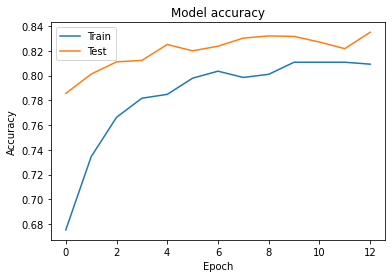

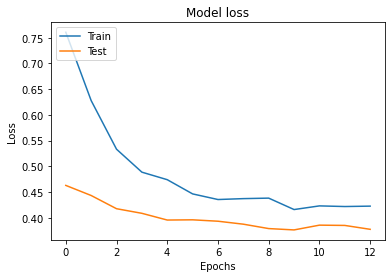

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()